In [1]:
import os
from sys import path
from time import time

import numpy as np

cwd = os.getcwd()
path.append(f"{cwd}/..")

from database import (create_tables, drop_tables, get_next_chunk_from_db,
                      reset_progression, save_dois, update_dois)
from doi_function import (compute_dois, reset_doi_component,
                          set_dimension_weights, set_dimension_intervals)

from server import taxi_process_chunk


def reset(weights: dict, intervals: dict): 
  drop_tables()

  create_tables(
      row_data_path="../data/nyc_taxis.shuffled_full.csv.gz",
      column_data_path="../data/nyc_taxis.shuffled_full.parquet",
      id_column="tripID",
      total_size=112145904,
      process_chunk_callback=taxi_process_chunk,
  )

  reset_progression()
  reset_doi_component()
  set_dimension_weights(weights)
  set_dimension_intervals(intervals)

doi_storage_ground_truth = {}
doi_storage_optimized = {}
doi_storage_baseline = {}

def benchmark(iterations: int, chunk_size: int, weights: dict, intervals: dict):

  ##################################################################################################
  # TEST_CASE
  ##################################################################################################
  reset(weights, intervals)
  now = time()
  for i in range(iterations):
    chunk = get_next_chunk_from_db(chunk_size)
    new_dois, updated_ids, updated_dois = compute_dois(chunk, use_optimizations=True)

    new_ids = np.array(chunk)[:, 0].tolist()
    updated_ids = np.array(updated_ids).tolist()

    save_dois(new_ids, new_dois.reshape(-1, ).tolist())
    update_dois(updated_ids, updated_dois.reshape(-1, ).tolist())

    for i, new_id in enumerate(new_ids):
      doi_storage_optimized[str(new_id)] = new_dois[i][0]

    for i, updated_id in enumerate(updated_ids):
      doi_storage_optimized[str(updated_id)] = updated_dois[i][0]

  print("optimized:", time() - now, "s")

  ##################################################################################################
  # BASELINE
  ##################################################################################################
  reset(weights, intervals)
  set_dimension_weights(weights)
  set_dimension_intervals(intervals)
  now = time()
  for i in range(iterations):
    chunk = get_next_chunk_from_db(chunk_size)
    new_dois, _, _ = compute_dois(chunk, use_optimizations=False)

    new_ids = np.array(chunk)[:, 0].tolist()

    for i, new_id in enumerate(new_ids):
      doi_storage_baseline[str(new_id)] = new_dois[i][0]
      
  print("baseline:", time() - now, "s")

  ##################################################################################################
  # GROUND TRUTH
  ##################################################################################################
  reset(weights, intervals)
  now = time()
  chunk = get_next_chunk_from_db(chunk_size * iterations)
  new_dois, _, _ = compute_dois(chunk, use_optimizations=False)

  new_ids = np.array(chunk)[:, 0].tolist()

  for i, new_id in enumerate(new_ids):
    doi_storage_ground_truth[str(new_id)] = new_dois[i][0]

  print("ground truth:", time() - now, "s")


ITERATIONS = 100
CHUNK_SIZE = 1000
WEIGHTS = {
  "trip_distance": 0.25,
  "total_amount": 0.25,
  "tip_amount": 0.25,
  "trip_duration": 0.25,
}
INTERVALS = {
  "trip_distance": [16, 20],
  "total_amount": [34, 74],
  "tip_amount": [4, 12],
  "trip_duration": [3, 5],
}

benchmark(ITERATIONS, CHUNK_SIZE, WEIGHTS, INTERVALS)

optimized: 146.8007435798645 s
baseline: 52.16898965835571 s
ground truth: 11.662999391555786 s


<AxesSubplot:>

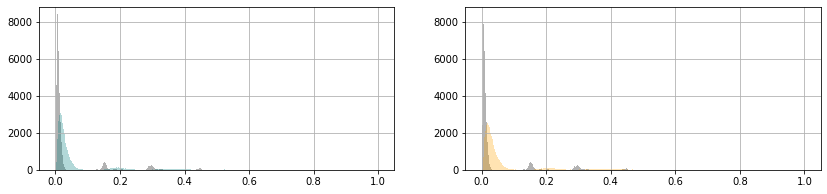

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

figsize = (14, 3)
fig, axes = plt.subplots(1, 2, figsize=figsize)

bin_size = 0.001
bins = np.arange(0, 1 + bin_size, bin_size)
pd.Series(doi_storage_ground_truth).hist(bins=bins, ax=axes[0], alpha=0.3, color="black")
pd.Series(doi_storage_optimized).hist(bins=bins, ax=axes[0], alpha=0.3, color="teal")

pd.Series(doi_storage_ground_truth).hist(bins=bins, ax=axes[1], alpha=0.3, color="black")
pd.Series(doi_storage_baseline).hist(bins=bins, ax=axes[1], alpha=0.3, color="orange")

In [4]:
import pandas as pd

gt_df = pd.Series(doi_storage_ground_truth).sort_index()
optimized_df = pd.Series(doi_storage_optimized).sort_index()
baseline_df = pd.Series(doi_storage_baseline).sort_index()


df = pd.DataFrame(columns=["gt", "baseline", "optimized"], index=gt_df.index)

df["gt"] = gt_df.to_numpy()
df["baseline"] = baseline_df.to_numpy()
df["optimized"] = optimized_df.to_numpy()

# sanity check:
assert (df["gt"] - gt_df).sum() == 0.0
assert (df["baseline"] - baseline_df).sum() == 0.0
assert (df.index != baseline_df.index).sum() == 0.0
assert (df["optimized"] - optimized_df).sum() == 0.0
assert (df.index != optimized_df.index).sum() == 0.0

baseline_error = df["gt"] - df["baseline"]
optimized_error = df["gt"] - df["optimized"]

"baseline", baseline_error.describe(), "optimized", optimized_error.describe()

('baseline',
 count    100000.000000
 mean         -0.028479
 std           0.030859
 min          -0.344976
 25%          -0.032551
 50%          -0.018979
 75%          -0.011182
 max          -0.000053
 dtype: float64,
 'optimized',
 count    100000.000000
 mean         -0.020795
 std           0.023960
 min          -0.255620
 25%          -0.023900
 50%          -0.013560
 75%          -0.007508
 max          -0.000002
 dtype: float64)

In [1]:
import os
from sys import path

cwd = os.getcwd()
path.append(f"{cwd}/..")
import numpy as np
import pandas as pd
from database import (create_tables, drop_tables, get_next_chunk_from_db,
                      reset_progression)
from doi_function import (compute_dois, reset_doi_component,
                          set_dimension_intervals, set_dimension_weights)
from sklearn.tree import DecisionTreeRegressor

from server import taxi_process_chunk


def reset(weights: dict, intervals: dict): 
  drop_tables()

  create_tables(
      row_data_path="../data/nyc_taxis.shuffled_full.csv.gz",
      column_data_path="../data/nyc_taxis.shuffled_full.parquet",
      id_column="tripID",
      total_size=112145904,
      process_chunk_callback=taxi_process_chunk,
  )

  reset_progression()
  reset_doi_component()
  set_dimension_weights(weights)
  set_dimension_intervals(intervals)


ITERATIONS = 100
CHUNK_SIZE = 1000
WEIGHTS = {
  "trip_distance": 0.25,
  "total_amount": 0.25,
  "tip_amount": 0.25,
  "trip_duration": 0.25,
}
INTERVALS = {
  "trip_distance": [16, 20],
  "total_amount": [34, 74],
  "tip_amount": [4, 12],
  "trip_duration": [3, 5],
}
reset(intervals=INTERVALS, weights=WEIGHTS)

chunk = get_next_chunk_from_db(CHUNK_SIZE)
new_dois, updated_ids, updated_dois = compute_dois(chunk, use_optimizations=False)

new_ids = np.array(chunk)[:, 0].tolist()
updated_ids = np.array(updated_ids).tolist()

df = pd.DataFrame(chunk)
df = df.drop(columns=[2, 3, 7, 18, 19])  # non-numerical columns
df = df.astype(np.float32)
df.columns = map(str, df.columns)

model = DecisionTreeRegressor(max_depth=10)
model.fit(df, new_dois)

DecisionTreeRegressor(max_depth=10)

In [2]:
import os
from sys import path

cwd = os.getcwd()
path.append(f"{cwd}/..")
import numpy as np
import pandas as pd
from database import (create_tables, drop_tables, get_next_chunk_from_db,
                      reset_progression, save_dois)
from doi_function import (compute_dois, reset_doi_component,
                          set_dimension_intervals, set_dimension_weights)

from server import taxi_process_chunk

from doi_regression_model import *
from storage_strategy.windowing_storage import WindowingStorage



def reset(weights: dict, intervals: dict): 
  drop_tables()

  create_tables(
      row_data_path="../data/nyc_taxis.shuffled_full.csv.gz",
      column_data_path="../data/nyc_taxis.shuffled_full.parquet",
      id_column="tripID",
      total_size=112145904,
      process_chunk_callback=taxi_process_chunk,
  )

  reset_progression()
  reset_doi_component()
  set_dimension_weights(weights)
  set_dimension_intervals(intervals)


ITERATIONS = 100
CHUNK_SIZE = 1000
WEIGHTS = {
  "trip_distance": 0.25,
  "total_amount": 0.25,
  "tip_amount": 0.25,
  "trip_duration": 0.25,
}
INTERVALS = {
  "trip_distance": [16, 20],
  "total_amount": [34, 74],
  "tip_amount": [4, 12],
  "trip_duration": [3, 5],
}
reset(intervals=INTERVALS, weights=WEIGHTS)

storage = WindowingStorage(max_size=10000000)

chunk = get_next_chunk_from_db(CHUNK_SIZE)
new_dois, updated_ids, updated_dois = compute_dois(chunk, use_optimizations=False)
new_ids = np.array(chunk)[:, 0].tolist()
updated_ids = np.array(updated_ids).tolist()
save_dois(new_ids, new_dois.reshape(-1, ).tolist())

chunk_df = pd.DataFrame(chunk)
chunk_df.rename(columns={0: "tripID"}, inplace=True)

df = chunk_df.drop(columns=[2, 3, 7, 18, 19])  # non-numerical columns
df = df.astype(np.float32)
df.columns = map(str, df.columns)
storage.insert_chunk(df, 0)

model = DoiRegressionModel(storage)
model.update(df, new_dois)
# model.get_context_items(10)

ls = model._get_leaf_nodes()

# it seems like something is off here, because some leaf nodes contain all the data and some are 
# empty
# [model._get_all_items_for_leaf_node(l) for l in ls]
[l.get_query() for l in ls]

['17 <= 33.079999923706055 AND 14 <= 3.9800000190734863',
 '17 <= 33.079999923706055 AND 14 > 3.9800000190734863',
 '17 > 33.079999923706055 AND 5 <= 16.450000762939453',
 '17 > 33.079999923706055 AND 5 > 16.450000762939453']